## Compare Synthetic with Observations

per pixel error estimates


In [1]:
import folium
import xskillscore as xs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb

import odc.geo.xr
from odc.geo.xr import assign_crs

In [2]:
model_var='NDVI'

In [3]:
yy = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/results/ml_predictions/'+model_var+'_predicted_5km_monthly_1982_2022.nc').rename({'y':'latitude', 'x':'longitude'})[model_var]
obs = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/'+model_var+'_harmonization/'+model_var+'_LGBM_5km_monthly_1982_2022_wGaps.nc')[model_var]

if model_var=='LST':
    yy = yy-273.15
    obs = obs-273.15

obs = obs.sel(time=yy.time)
# obs = obs[model_var].rename({'latitude':'y', 'longitude':'x'})
gaps_mask = ~np.isnan(obs)
 
yy = yy.where(gaps_mask)

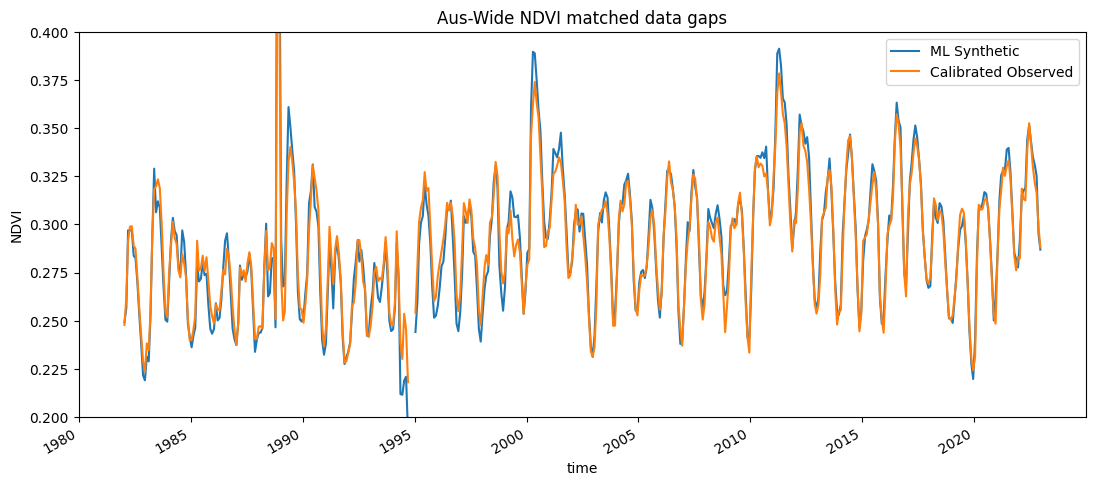

In [4]:
fig, ax = plt.subplots(1,1, figsize=(13,5))
yy.mean(['latitude','longitude']).plot(ax=ax, label='ML Synthetic')
obs.mean(['latitude','longitude']).plot(ax=ax, label='Calibrated Observed')
ax.set_ylim(0.20, 0.40)
ax.legend()
ax.set_title('Aus-Wide '+model_var+ ' matched data gaps');

### Error metrics

In [5]:
pred_mean = yy.mean('time')
obs_mean = obs.mean('time')
obs_mask = ~np.isnan(obs_mean)
low_ndvi_mask = xr.where(obs.mean('time')<0.10,0, 1)
pred_mean = pred_mean.where(obs_mask)
pred_mean = pred_mean.where(low_ndvi_mask)
obs_mean = obs_mean.where(low_ndvi_mask)

In [6]:
corr = xr.corr(obs, yy, dim='time').rename('Pearson Correlation')
corr = corr.where(low_ndvi_mask)
corr = corr.where(obs_mask)

mape = xs.mape(obs,yy, dim='time', skipna=True).rename('MAPE')
mape = mape*100
mape = mape.where(mape<200) #get rid of massive numbers from dividng near zero
mape = mape.where(low_ndvi_mask)
mape = mape.where(obs_mask)

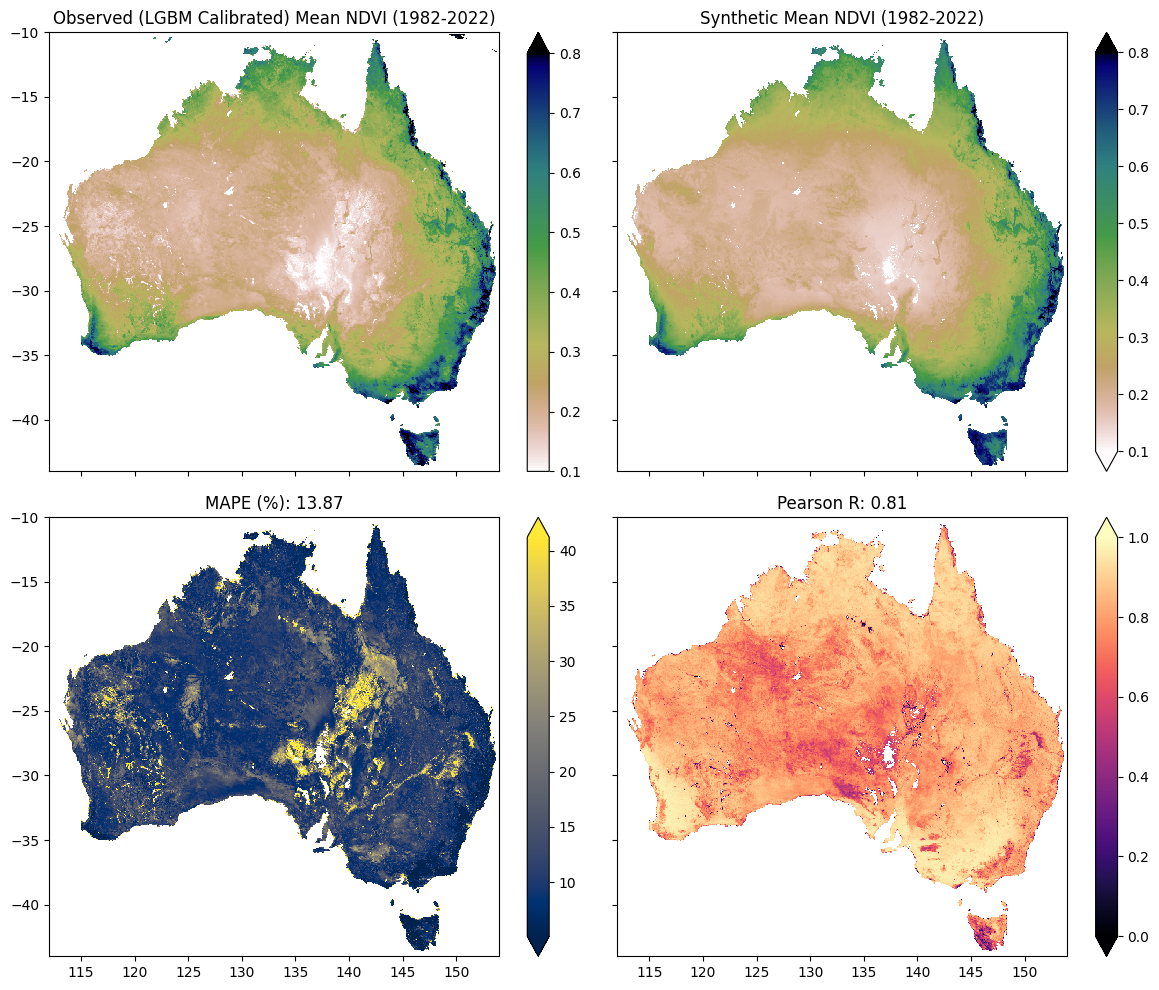

In [7]:
fig, ax = plt.subplots(2,2, figsize=(12,10), sharey=True, sharex=True)
obs_mean.plot.imshow(ax=ax[0,0], cmap='gist_earth_r', vmin=0.1, vmax=0.8, add_labels=False)
pred_mean.plot.imshow(ax=ax[0,1], cmap='gist_earth_r', vmin=0.1, vmax=0.8, add_labels=False)

mape.plot.imshow(ax=ax[1,0], robust=True, add_labels=False, cmap='cividis')
corr.plot.imshow(ax=ax[1,1], cmap='magma', vmin=0.0, vmax=1.0, add_labels=False)

ax[0,0].set_title('Observed (LGBM Calibrated) Mean NDVI (1982-2022)')
ax[0,1].set_title('Synthetic Mean NDVI (1982-2022)')

ax[1,0].set_title(f'MAPE (%): '"{:.2f}".format(mape.mean().values))
ax[1,1].set_title(f'Pearson R: '"{:.2f}".format(corr.mean().values))

plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/Error_metrics_synthetic_"+model_var+".png",
            bbox_inches='tight', dpi=300)

In [8]:
# m = folium.Map(control_scale = True)

# # assign_crs(corr, crs='EPSG:4326').odc.add_to(m, vmin=0.5, vmax=1.0, cmap='magma')
# assign_crs(mae, crs='EPSG:4326').odc.add_to(m, robust=True, cmap='inferno')

# # Zoom map to Australia
# m.fit_bounds(corr.odc.map_bounds())

# tile = folium.TileLayer(
#         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#         attr = 'Esri',
#         name = 'Esri Satellite',
#         overlay = True,
#         control = True
#        ).add_to(m)

# folium.LayerControl().add_to(m)
# display(m)